In [264]:
from __future__ import print_function, division
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [265]:
from scipy.signal import fftconvolve
def lorentzian_filter(spread=5.0, size=30):
    x = np.arange(-size, size+1, 1, dtype=np.float)
    kernel = (spread / 2.0) / (x ** 2 + spread ** 2.0 / 2) / np.pi
    return kernel / kernel.sum()

def generate_dIdV(Ed, slope=1.0, broadening=5.0, noise=1e-3, num_points=512):
    """
    Simulate dIdV map.
    num_points will be evaluated at evenly spaced from -1V to 1V
    
    """
#     assert Ed > 0.065 or Ed < -0.065
    V = np.linspace(-1, 1, num_points * 2)
    dIdV = slope * np.abs(V - Ed)
    phonon_gap = (V < 0.065) & (V > -0.065)
    dIdV[phonon_gap] = 0
    if Ed < 0:
        right_most = dIdV[V < -0.065][-1]
        V_right = V[V > 0.065]
        V_right -= np.min(V_right)
        dIdV[V > 0.065] = slope * np.abs(V_right) + right_most
    else:
        left_most = dIdV[V > 0.065][0]
        V_left = V[V < -0.065]
        V_left -= np.max(V_left)
        dIdV[V < -0.065] = slope * np.abs(V_left) + left_most
    dIdV = fftconvolve(dIdV, 
                       lorentzian_filter(spread=broadening), 
                       mode='same')
    dIdV += noise * np.random.rand(len(dIdV))
    out_V = np.linspace(-0.5, 0.5, num_points)
    out_dIdV = np.interp(out_V, V, dIdV)
    return out_V, out_dIdV

(0.0, 1.0)

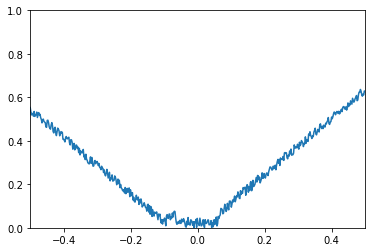

In [266]:
V, dIdV = generate_dIdV(-0.1, slope=1.3, noise=5e-2, broadening=1)
plt.plot(V, dIdV)
plt.xlim(-0.5, 0.5)
plt.ylim(0, 1)

In [359]:
from torch.utils.data import Dataset, DataLoader
import random
class STS_Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, slopes=(1.35, 2.5), broadening=(5, 35), noise=(1e-3, 4e-3)):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.min_slope, self.max_slope = slopes
        self.min_broad, self.max_broad = broadening
        self.min_noise, self.max_noise = noise
        np.random.seed(0)

    def __len__(self):
        return 10

    def __getitem__(self, idx):
        Ed_plus, Ed_minus = random.uniform(0.065, 0.3), -random.uniform(0.065, 0.3)
        Ed = random.choice([Ed_plus, Ed_minus])
        slope = random.uniform(self.min_slope, self.max_slope)
        broadening = random.uniform(self.min_broad, self.max_broad)
        noise = random.uniform(self.min_noise, self.max_noise)
        V, dIdV = generate_dIdV(Ed, slope=slope, broadening=broadening, noise=noise)
        sample = {'spectra' : dIdV.astype(np.double), 'Ed' : np.array([Ed], dtype=np.double)}
        return sample
        
sts_dataset = STS_Dataset()

torch.Size([1, 512])


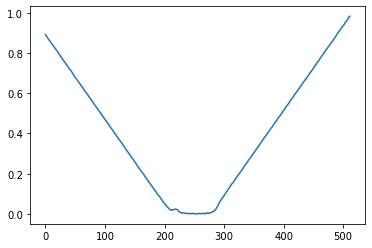

In [360]:
dataloader = DataLoader(sts_dataset, batch_size=1, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    spectra, Ed = sample_batched['spectra'], sample_batched['Ed']
    print(spectra.shape)
    # observe 4th batch and stop.
    plt.plot(spectra[0])
    break

In [361]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.norm1 = nn.BatchNorm1d(1)
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=12, kernel_size=30, stride=2)
#         self.conv2 = nn.Conv1d(in_channels=12, out_channels=24, kernel_size=5, stride=1)
#         self.drop1 = nn.Dropout()
#         self.conv3 = nn.Conv1d(in_channels=24, out_channels=36, kernel_size=3, stride=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(512, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 1)

    def forward(self, x):
        x = self.norm1(x)
#         x = F.max_pool1d(F.relu(self.conv1(x)), 5)
#         x = F.relu(self.conv2(x))
#         x = self.drop1(x)
#         x = F.max_pool1d(F.relu(self.conv3(x)), 3)
        # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net().double()
print(net)

Net(
  (norm1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)


In [372]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=1e-8)
criterion = nn.MSELoss()
net.zero_grad()
NUM_EPOCHS = 50
training_losses = []
validation_losses = []
V = np.linspace(-1, 1, 512)
for _ in range(NUM_EPOCHS):
#     print(_)
    t_loss = []
    v_loss = []
    for i_batch, sample_batched in enumerate(dataloader):
      spectra, Ed = \
              sample_batched['spectra'], sample_batched['Ed']
      output = net(spectra[:, np.newaxis, :].double())
#       print(output.item() - Ed.item())
      loss = criterion(output, Ed)
      if i_batch < 8: # only train on first 32 persons
        optimizer.zero_grad()
        t_loss.append(loss)
        loss.backward()
        optimizer.step()
      else: # validation accuracy
        v_loss.append(loss)
    training_losses.append(torch.mean(torch.tensor(t_loss)))
    validation_losses.append(torch.mean(torch.tensor(v_loss)))

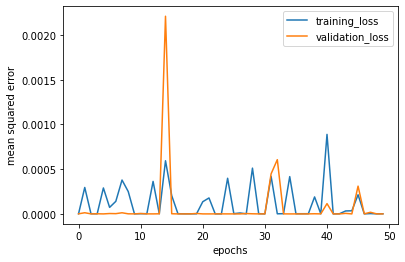

In [373]:
plt.plot(training_losses, label="training_loss")
plt.plot(validation_losses, label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.legend()

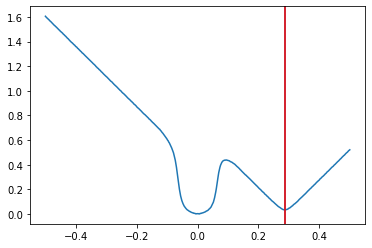

In [374]:
V = np.linspace(-0.5, 0.5, 512)
for i in range(1):
    plt.figure()
    plt.plot(V, spectra[i])
    plt.axvline(x=output[i])
    plt.axvline(x=Ed[i], color='r')

In [375]:
def file2df(file):
    with open(file,'r') as f:
        for i in range(70): # 70 for .dat, 8 for transport__.dat
            f.readline()
        df = pd.read_table(f)
        df = df.rename(columns={"Bias calc (V)": "V", "LI Y [AVG] (V)": "LIY"})
        return df

class expDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, folder, numbers):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.folder = folder
        self.start, self.end = numbers

    def __len__(self):
        return self.end - self.start + 1

    def __getitem__(self, idx):
        filepath = self.folder + '{0:03}.dat'.format(idx + self.start)
        df = file2df(filepath)
        sample = {'spectra': df.LIY.values, 'V': df.V.values}
        return sample
        
expdata = expDataset("electromigration_8/GBN_ET2_", (508, 569))


/home/a/as/asai/miniconda3/envs/ednn/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


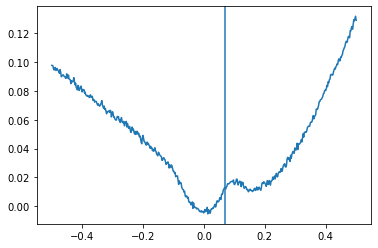

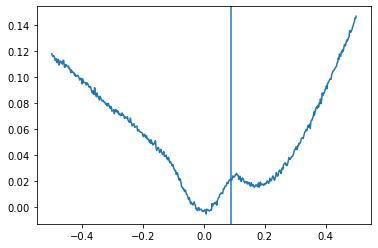

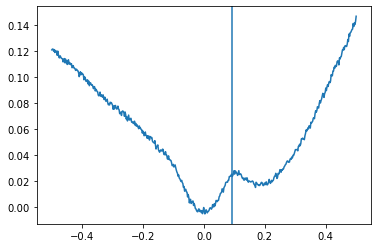

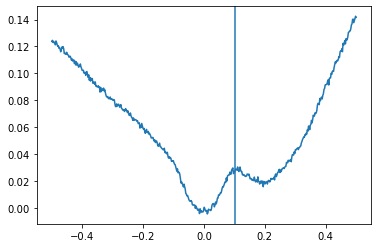

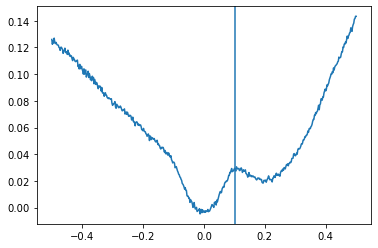

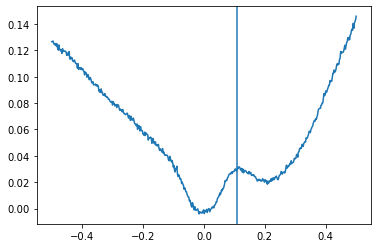

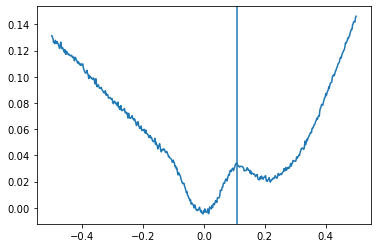

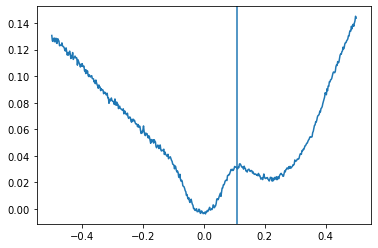

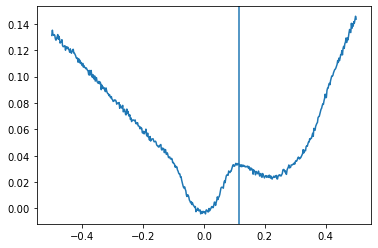

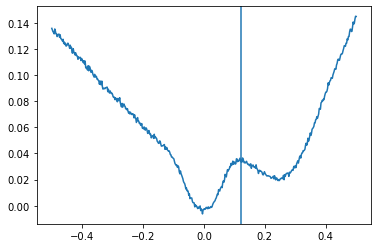

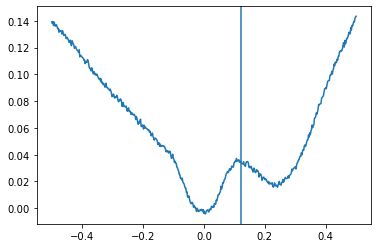

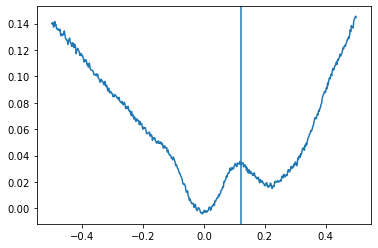

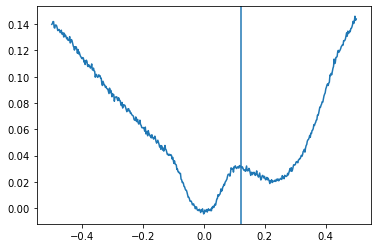

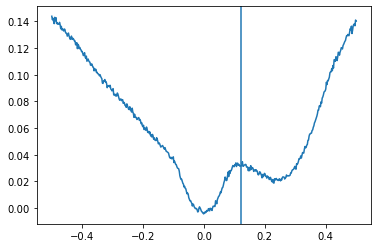

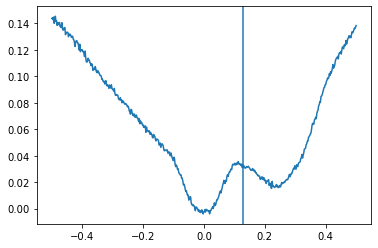

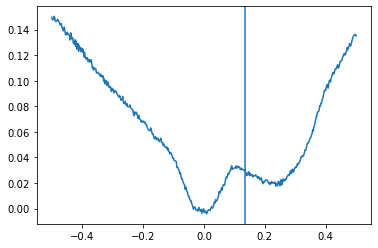

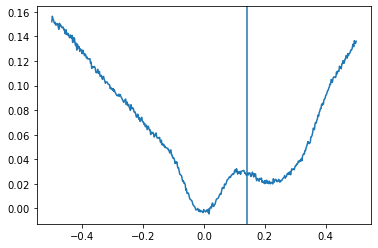

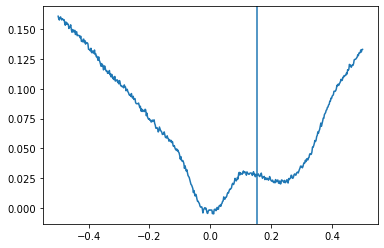

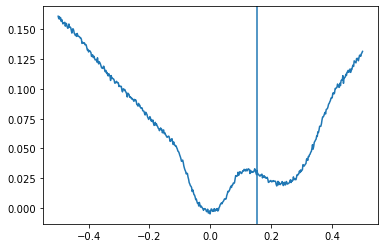

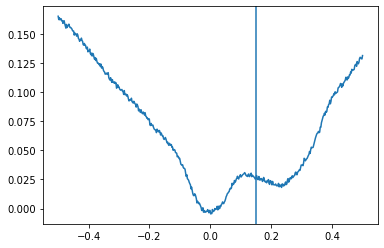

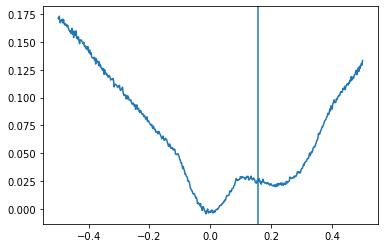

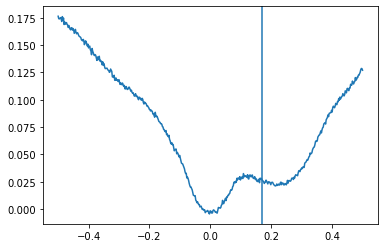

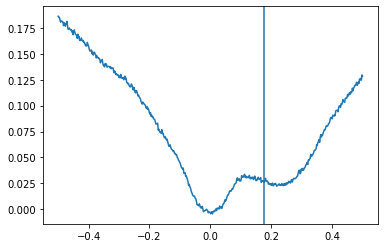

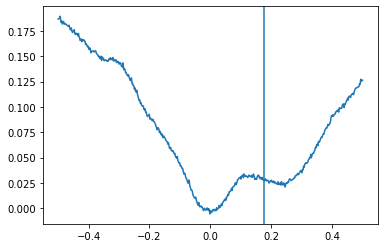

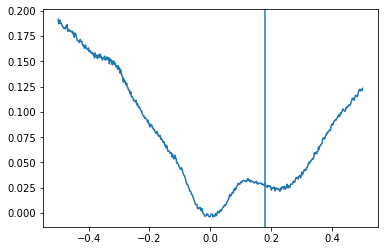

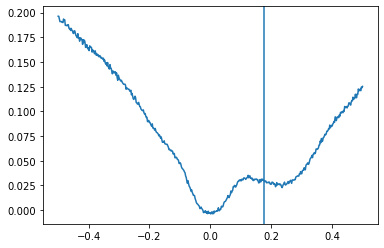

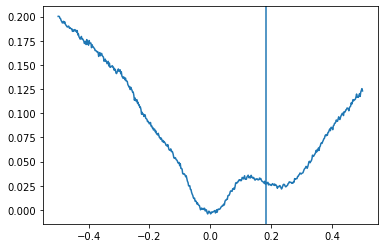

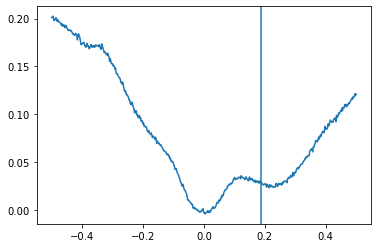

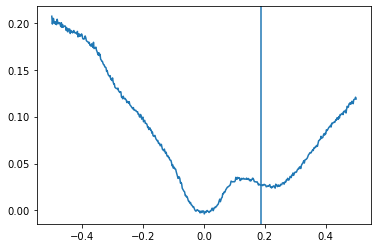

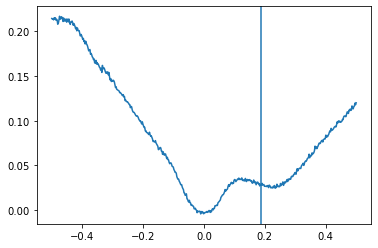

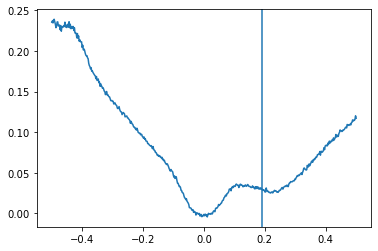

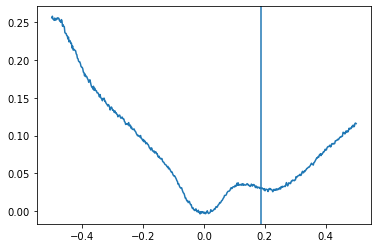

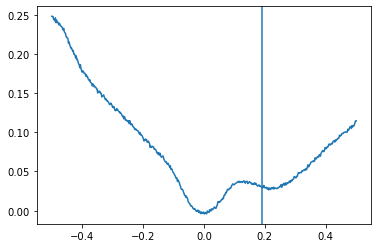

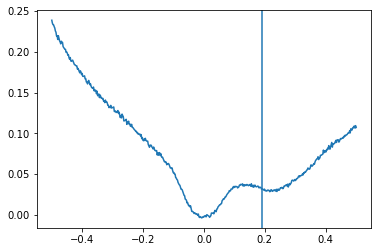

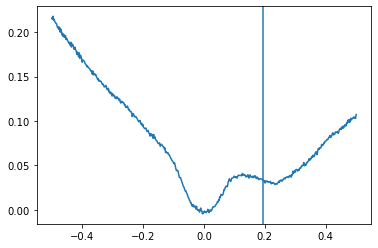

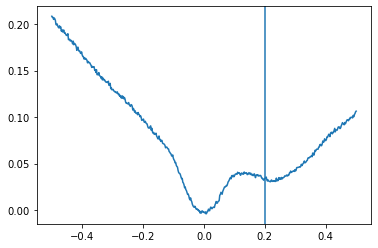

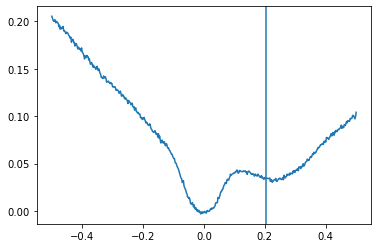

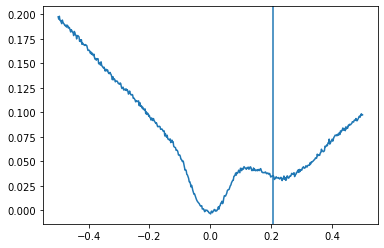

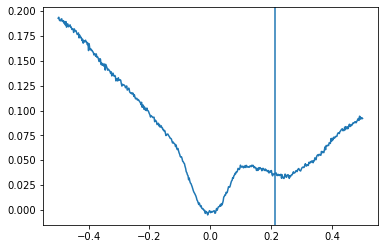

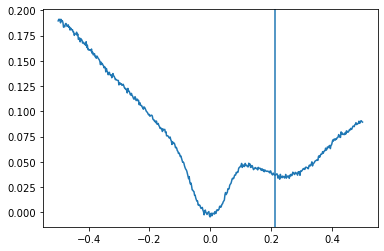

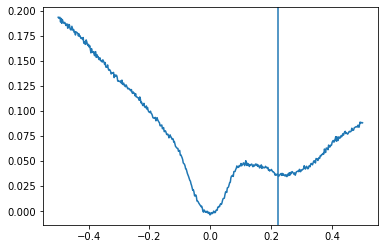

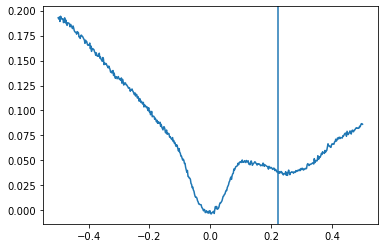

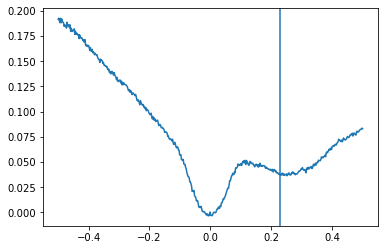

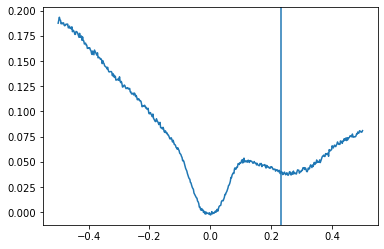

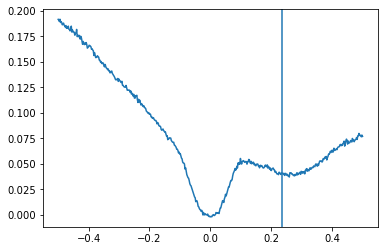

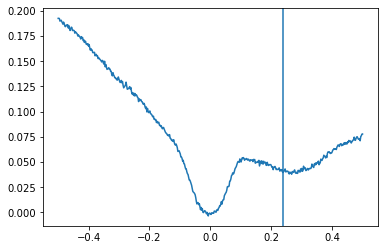

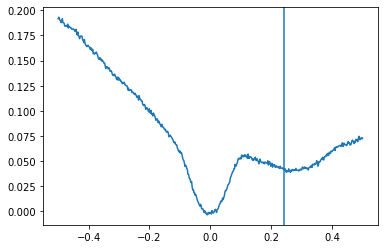

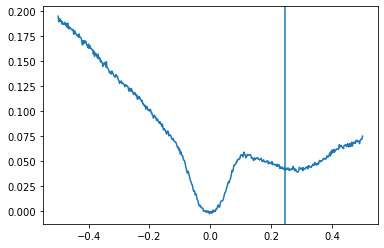

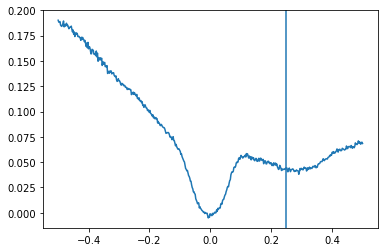

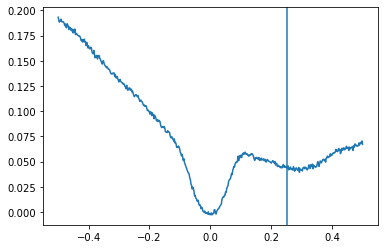

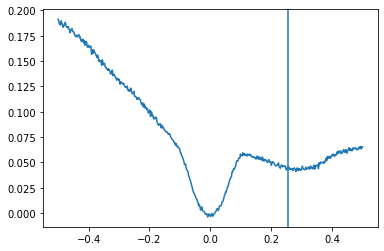

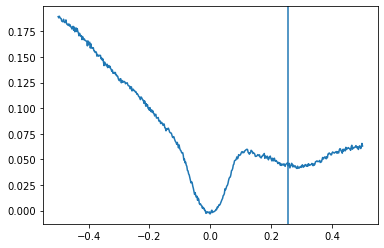

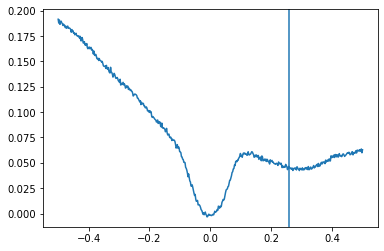

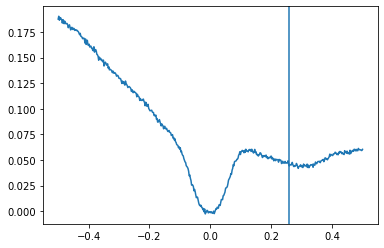

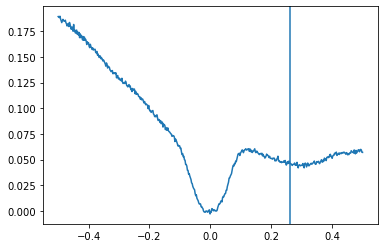

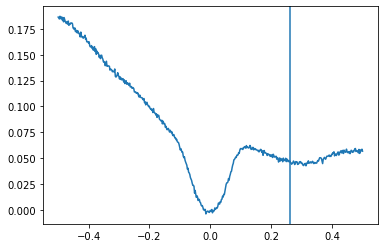

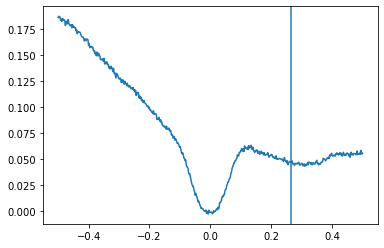

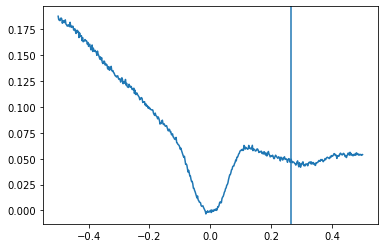

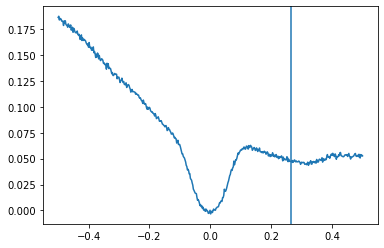

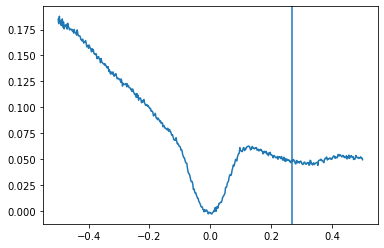

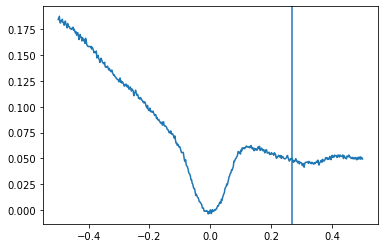

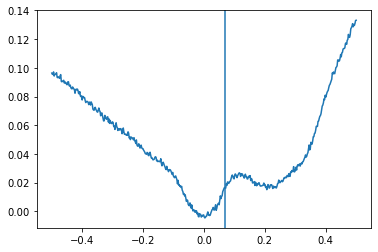

In [376]:
dataloader = DataLoader(expdata, batch_size=1, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    spectra, V = sample_batched['spectra'], sample_batched['V']
    # observe 4th batch and stop.
    output = net(spectra[:, np.newaxis, :].double())
    plt.figure()
    plt.plot(V[0], spectra[0])
    plt.axvline(x=-output.item())